# Final Project - Movie Reviews Analysis
- **Team 13: Jimmy Nguyen, Dallin Munger, Tyler Wolff**
- Date: 06/20/2022


# Packages

In [1]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from requests import TooManyRedirects
import re
import omdb
import time
from collections import Counter, defaultdict
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from string import punctuation
sw = stopwords.words("english")

---- 
# Loading the Raw Data from API

In [2]:
# Read in csv data as pandas data frame
movies_info = pd.read_csv("Raw Movie Data.csv")
# see a random subset of 15 samples
movies_info.shape

(5000, 25)

In [3]:
movies_info.sample(10)

,title,year,rated,released,runtime,genre,director,writer,actors,plot,...,metascore,imdb_rating,imdb_votes,imdb_id,type,dvd,box_office,production,website,response
351,One Under the Sun,2017,TV-14,14 Mar 2017,101 min,"Drama, Mystery, Sci-Fi","Riyaana Hartley, Vincent Tran","Katherine Tomlinson, Vincent Tran","Pooja Batra, Gene Farber, Michael Keeley","Astronaut Kathryn Voss, sole survivor of a dis...",...,NaN,3.5,612,tt5110386,movie,14 Mar 2018,NaN,NaN,NaN,True
2313,Square One,2013,NaN,15 Aug 2013,15 min,"Short, Comedy",Emanuel Parvu,Emanuel Parvu,"Dorian Boguta, Dorina Lazar, Emanuel Parvu, Co...",NaN,...,NaN,6.6,7,tt6479182,movie,NaN,NaN,NaN,NaN,True
2518,You Are the One: The Claudine-Raymart Love Story,2006,NaN,26 Mar 2006,NaN,"Documentary, Music",NaN,NaN,"Claudine Barretto, Raymart Santiago, Dennis Pa...",NaN,...,NaN,5.3,5,tt0787250,movie,NaN,NaN,NaN,NaN,True
4525,One Day Over L.A.,2014,NaN,NaN,3 min,"Documentary, Short, Adventure",Cole Kawana,Cole Kawana (story),NaN,Harvard-Westlake sophomore Cole Kawana flies h...,...,NaN,NaN,NaN,tt4540802,movie,NaN,NaN,NaN,NaN,True
38,The Son of No One,2011,R,09 Jul 2011,90 min,"Action, Crime, Drama",Dito Montiel,Dito Montiel,"Channing Tatum, Al Pacino, Juliette Binoche",A young cop is assigned to a precinct in the w...,...,36.0,5.1,"17,137",tt1535612,movie,21 Feb 2012,"$30,680",NaN,NaN,True
3123,"One Sight, One Sound",2009,NaN,NaN,75 min,"Documentary, Music",Josh Pomponio,NaN,NaN,September-November 2008; three months with the...,...,NaN,NaN,NaN,tt1567653,movie,NaN,NaN,NaN,NaN,True
4544,One Day in Perfect Health,1950,NaN,NaN,18 min,"Documentary, Short",John Krish,NaN,NaN,NaN,...,NaN,NaN,NaN,tt2064890,movie,NaN,NaN,NaN,NaN,True
2639,One Black Coffee,2019,NaN,30 Mar 2019,NaN,Short,Manoj Mathew,Manoj Mathew,"Manoj Mathew, Babli Das, Kasturi Banerjee, Tar...",NaN,...,NaN,NaN,NaN,tt11062440,movie,NaN,NaN,NaN,NaN,True
507,One Damned Day at Dawn... Django Meets Sartana!,1970,NaN,25 Jun 1970,90 min,Western,Demofilo Fidani,"Demofilo Fidani, Mila Vitelli Valenza","Jack Betts, Fabio Testi, Dino Strano","Framed for a bank robbery, bounty killer Djang...",...,NaN,4.9,329,tt0067643,movie,NaN,NaN,NaN,NaN,True
1224,One Direction: What Makes You Beautiful,2011,NaN,19 Aug 2011,3 min,"Short, Music",John Urbano,NaN,"One Direction, Harry Styles, Louis Tomlinson, ...","Official music video for ""What Makes You Beaut...",...,NaN,7.2,45,tt7318548,movie,NaN,NaN,NaN,NaN,True


------
# Exploratory Data Analysis

1. Examine a five-number summary of the numerical and categorical columns
2. Checking for Missing Data
3. Plotting Value Distribtuions 
4. Comparing Value Distributions Across Categories

## 1. Calculating Summary Statistics for Columns

In [4]:
# Create a new column to look at the length of each plot
movies_info['plot_length'] = movies_info['plot'].str.len()

# 5 number summary of the numerical columns
movies_info.describe().T

,count,mean,std,min,25%,50%,75%,max
year,5000.0,2002.897000,23.082681,1887.0,2002.0,2011.0,2016.0,2023.0
metascore,115.0,60.026087,18.559747,16.0,47.0,62.0,74.0,93.0
imdb_rating,2442.0,6.591155,1.386458,1.0,5.8,6.7,7.5,10.0
plot_length,3560.0,159.808989,70.963086,16.0,109.0,170.0,208.0,1324.0


**Interpretation**
1. **Year:** The range of the movies pulled from the API is from the year 1887 to 2023. This may seem plausible, but requires more drilling down in the data to figure out if the first movie ever was actually made in 1887. For movies in the year 2023, this may be upcoming movies that will be released then.

2. **Metascore**: The metascore is a weighted average of many reviews coming from reputed critics. The Metacritic team reads the reviews and assigns each a 0–100 score, which is then given a weight, mainly based on the review's quality and source. That means the higher the metascore, the more positive reviews a movie has. In our summary, we can see that the range for our movies in this sample is from 16 as the lowest and 93 as the highest. The average metascore is 60, where as the median is 62. This can be interesting later as we dive into the average metascore over time.

3. **imdb_rating**: IMDB rating allow users to rate films on a scale of 1-10. As expected, the range for this variable is 1 as the lowest and 10 as the highest. However, the average IMDB rating is 6.6 and the median is 6.7.

4. **plot_length**: This column displays the length of each movies' plot. Movies plots length range from 16 words as the lowest to 208 as the highest. On average, a movie plot has the length of 160 words whereas the median is 170. This could also indicate that a longer plot description will provide more information to understanding the movies' genres.

In [5]:
movies_info[['awards','runtime', 'language', 'country']].describe(include = 'O').T

,count,unique,top,freq
awards,840,177,1 nomination,139
runtime,3826,173,4 min,163
language,4586,233,English,3414
country,4797,321,USA,1444


**Interpretation**

1.**awards** This variable shows that 139 movies out of 5000 were able to receive 1 nomination for an award. However, due to the number of unique values, we may need to consider that awards recorded down for each movie is not consistent since this has a high cardinality. Therefore, this may not be a reliable insight for the awards variable

2. **runtime** This variable also sees a high cardinality, but at a quick glance we can see that there are 163 movies that has a runtime of only 4 minutes. 

3. **language** There number of unique languages here is 233, while that may seem plausible it is also expected to see that movies in English was most prevalent.

4. **country** Understandably, the country with the most movies are from the United States of America (USA). Exactly 1444 movies out of 5000 in this API sample are American.

## 2. Checking for Missing Data

In [6]:
movies_info.isna().sum()

title             0
year              0
rated          4245
released       1349
runtime        1174
genre           159
director        415
writer         1435
actors          754
plot           1440
language        414
country         203
awards         4160
poster         2180
ratings           0
metascore      4885
imdb_rating    2558
imdb_votes     2446
imdb_id           0
type              0
dvd            4497
box_office     4884
production     4965
website        4996
response          0
plot_length    1440
dtype: int64

In [7]:
# Only working with rows where plot AND genre is not null
movies_info = movies_info[(movies_info['plot'].notnull()) & (movies_info['genre'].notnull())]
movies_info.shape

(3510, 26)

**Interpretation**

Since our project is based on classifying the first genre of every movie based on its plot, then we only need to take into consideration the `plot` and `genre` columns to prepare for modeling


## 3. Plotting Value Distribtuions 

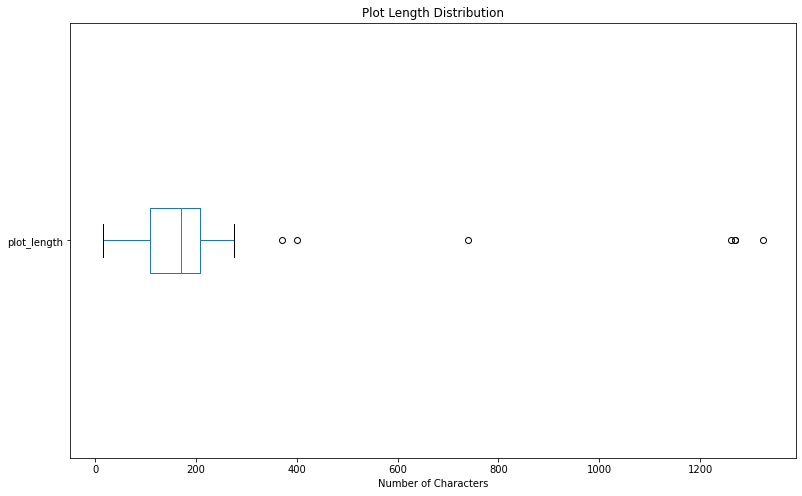

In [8]:
## Plotting Value Distribtuions 
plt.figure(figsize=(13,8))
movies_info['plot_length'].plot(kind='box', vert=False)
plt.xlabel('Number of Characters')
plt.title('Plot Length Distribution')
plt.show()

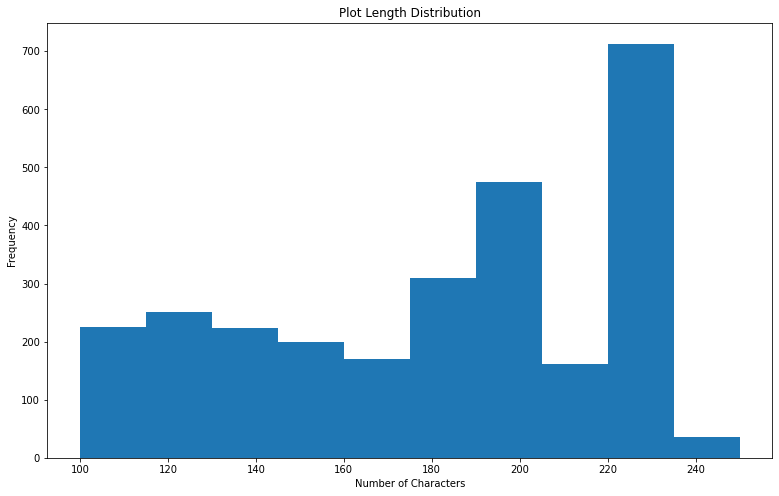

In [9]:
# Histogram distribution of movie plot lengths
plt.figure(figsize=(13,8))
movies_info['plot_length'].plot(kind = 'hist', range = (100,250))
plt.xlabel('Number of Characters')
plt.title('Plot Length Distribution')
plt.show()

**Interpretation**

After removing the missing values, 50% percent of the plot descriptions have a length between roughly 150 and 230 characters, with the median at about 180 with many outliers to the right. The distribution is obviously left-skewed. 

The histogram is showing the bins for the number of characters between the ranges of 100 to 250.

## 4. Comparing Value Distributions Across Categories

In [10]:
# top 10 countries with most movie plot descriptions
movies_info['country'].value_counts().nlargest(10)

United States     885
USA               883
UK                174
United Kingdom    155
Canada            139
Japan              81
Australia          78
France             62
India              57
Italy              43
Name: country, dtype: int64

In [11]:
# Replace United States Values
movies_info['country'] = movies_info['country'].str.replace(r'USA','United States', regex=True)

# Replace UK Values
movies_info['country'] = movies_info['country'].str.replace(r'UK', 'United Kingdom', regex=True)

# top 10 countries with most movie plot descriptions
movies_info['country'].value_counts().nlargest(10)

United States     1768
United Kingdom     329
Canada             139
Japan               81
Australia           78
France              62
India               57
Italy               43
Germany             37
China               26
Name: country, dtype: int64

Text(2.6970000000000027, 0.5, 'Plot length')

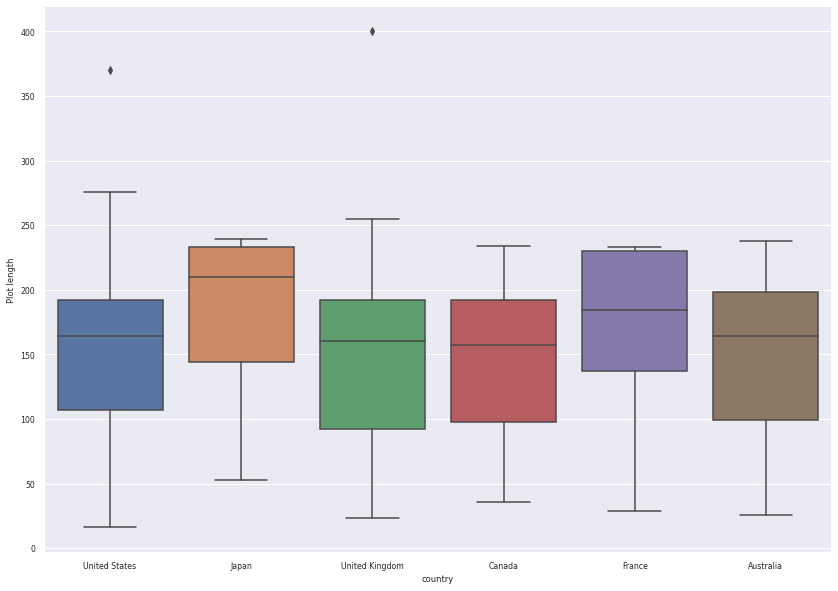

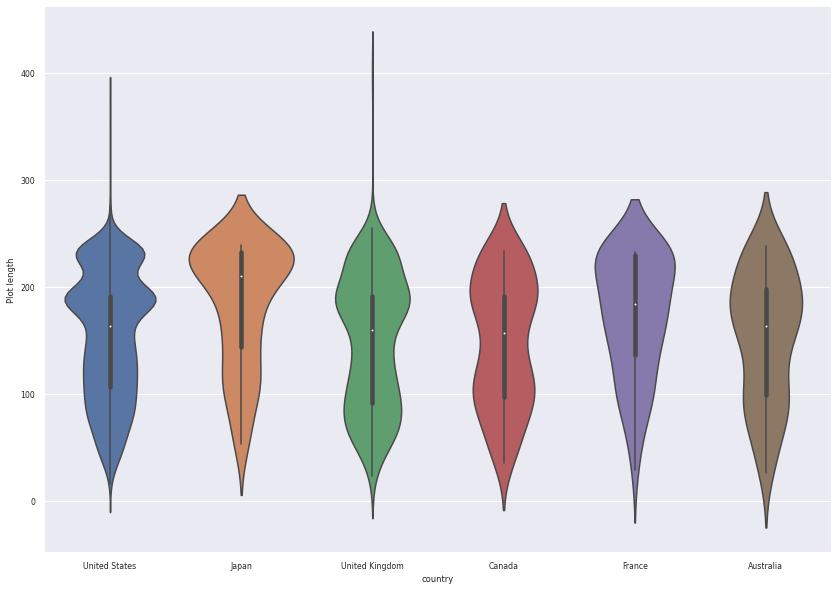

In [12]:
# Boxplot and violint plots for movie plot lengths by countries
sns.set(font_scale = 0.7)
where = movies_info['country'].isin(['United States', 'United Kingdom', 'Canada', 'Japan', 'Australia', 'France'])
sns.catplot(data=movies_info[where], x="country", y="plot_length", kind='box', height=8.27, aspect=11.7/8.27)
plt.ylabel("Plot length")
sns.catplot(data=movies_info[where], x="country", y="plot_length", kind='violin', height=8.27, aspect=11.7/8.27)
plt.ylabel("Plot length")

**Interpretation** 

Both plots reveal that the lengths of the movie plots, for Japan has a higher median number of characters than the rest, otherwise all other countries seem to be closely distributed around the same length for movie plots.



## 5. Visualizing Movie Plots Over Time

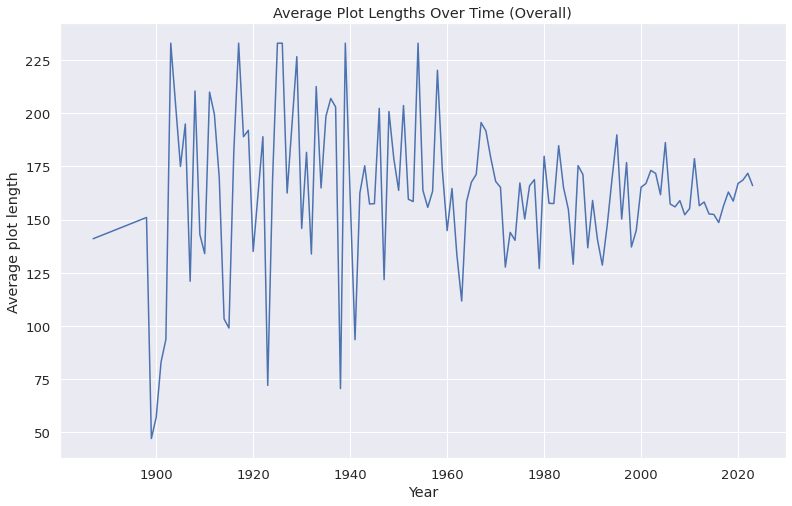

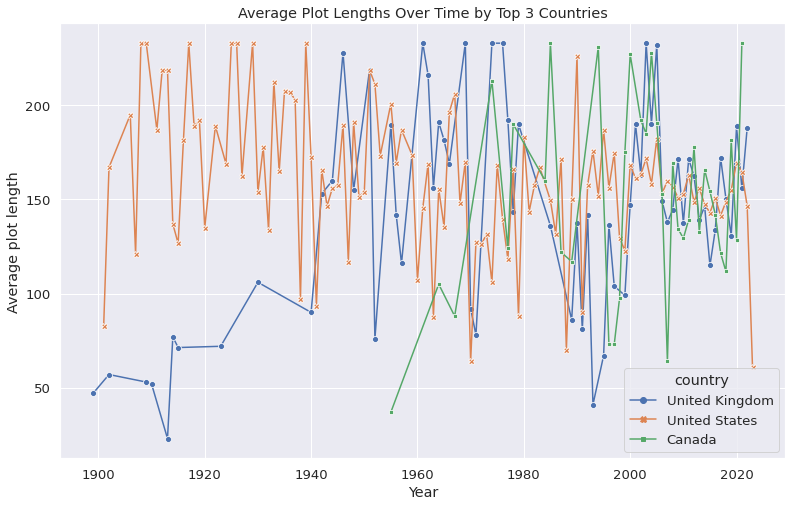

In [13]:
# Average plot lengths over 
plots_avg = movies_info.groupby(['year'])['plot_length'].mean().reset_index()


# time series plot of average plot length overall
plt.figure(figsize=(13,8))
sns.set(font_scale = 1.2)
sns.lineplot(data=plots_avg, x="year", y="plot_length")
plt.title("Average Plot Lengths Over Time (Overall)")
plt.xlabel("Year")
plt.ylabel("Average plot length")
plt.show()


# Average plot lengths over time by countries
plt.figure(figsize=(13,8))
plots_over_time = movies_info.groupby(['year','country'])['plot_length'].mean().reset_index()
where = plots_over_time['country'].isin(['United States', 'United Kingdom','Canada'])
plots_over_time = plots_over_time[where]

# time series plot of average plot length by countries
sns.lineplot(data=plots_over_time, x="year", y="plot_length", hue="country", style = "country",
    markers=True, dashes=False)
plt.title("Average Plot Lengths Over Time by Top 3 Countries")
plt.xlabel("Year")
plt.ylabel("Average plot length")
plt.show()

**Intepretation**

The timeline reflects the number of average movie plot lengths over the years with all the countries, then a second plot aggregating by the top 3 countries with the most movies avaliable in this sample, which is the United States, United Kingdom, and Canada. Overall, movies across all countries in this sample have created shorter movie plot descriptions over time, whereas in the top 3 countries, any real pattern is hard to distinguish as there are a lot of variations.

# Preparing Texual Data for Statistics and Modeling

- Remove Punctuation 
- Remove extra white space
- Tokenize on white space pattern
- Fold to lowercase
- Remove stopwords

In [14]:
punctuation = set(punctuation) 
# Text cleaning function
def clean_text_data(column):
    new_description = []
    for description in column:
        update_desc = description
        # Remove the punctuation from each description
        for i in description:
            if i in punctuation:
                update_desc = update_desc.replace(i, "")
        # Remove extra white space
        update_desc = re.sub(r'\s+', ' ', update_desc)
        # Split on whitespace
        update_desc = update_desc.split()
        # Fold to lowercase
        for i in range(len(update_desc)):
            update_desc[i] = update_desc[i].lower()
        # Remove stopwords
        update_desc = [i for i in update_desc if i not in sw]
        new_description.append(update_desc)
    return new_description

In [15]:
#Remove empty lists from cleaned_genre
movies_info = movies_info[movies_info['genre'] != ' ']

# Clean the plot description and genre text
movies_info['cleaned_plot'] = clean_text_data(movies_info['plot'])
movies_info['cleaned_genre'] = clean_text_data(movies_info['genre'])

# Keep only the first word in the cleaned genre lists
movies_info['first_genre'] = [i[0] for i in movies_info['cleaned_genre']]

# Create new df with only the first_genre and cleaned_plot columns
cleaned_df = movies_info[['title', 'first_genre', 'cleaned_plot', 'imdb_rating']]
cleaned_df.sample(15)

,title,first_genre,cleaned_plot,imdb_rating
4856,And Then There Was One,short,"[woman, discovers, shes, pregnant, finds, husb...",NaN
494,One Day You'll Understand,drama,"[man, endeavors, collect, memories, grandparen...",5.7
436,One in a Thousand,drama,"[iris, expelled, school, spends, days, cousins...",6.3
1787,Fifty People One Question,documentary,"[one, town, 50, different, people, one, diffic...",5.8
4293,One Year Later,short,"[one, year, later, spooky, halloween, fairytal...",NaN
4318,One Pillow One Soul,family,"[story, tomb, removal, story, conflict, family...",NaN
2998,I Am the Other One,documentary,"[luca, longs, lost, love, thalles, name, chang...",NaN
3758,One Minute to Midnight,short,"[friendship, two, teenage, boys, imminent, nuc...",NaN
488,Sam Smith: I'm Not the Only One,short,"[music, video, sam, smiths, song, know, im, one]",8.2
1540,One Small Step,short,"[dasani, 9, attempts, juggle, responsibilities...",8.8


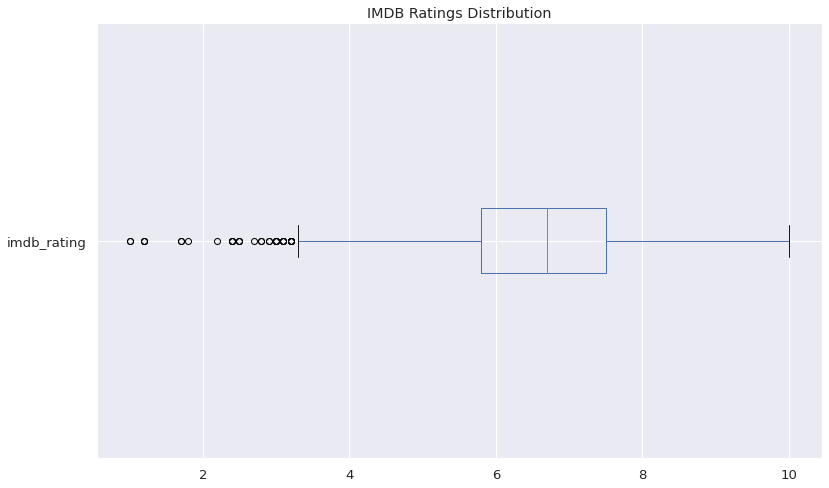

In [16]:
# Plotting Value Distribtuions 
plt.figure(figsize=(13,8))
sns.set(font_scale = 1.2)
cleaned_df['imdb_rating'].plot(kind='box', vert=False)
plt.title('IMDB Ratings Distribution')
plt.show()

In [17]:
# Count instances of each genre
cleaned_df['first_genre'].value_counts()

short          1342
documentary     743
drama           428
comedy          380
animation       145
action          132
crime            71
horror           40
adventure        35
thriller         32
music            32
biography        20
family           19
western          17
romance          15
scifi            15
sport             9
fantasy           9
mystery           9
musical           5
history           5
realitytv         3
talkshow          3
news              1
Name: first_genre, dtype: int64

## Only use top 5 first genres

- Include descriptive statistics on final clean data set
- Frequency Diagram
- Word cloud

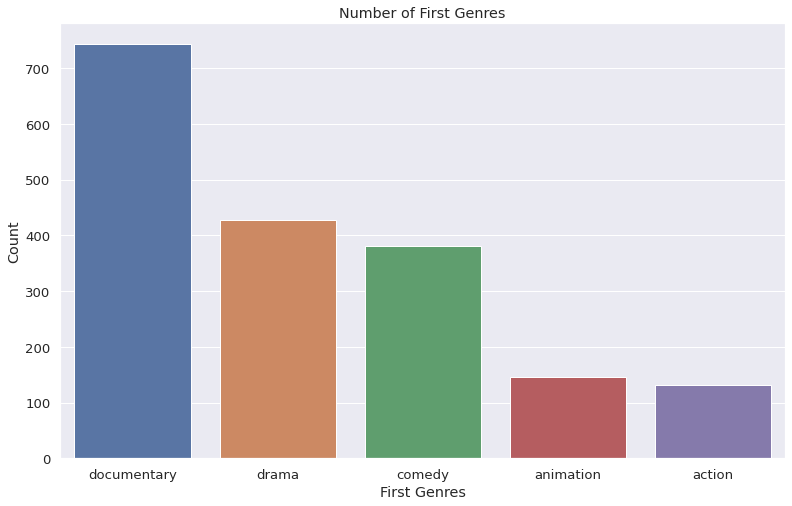

In [18]:
# Include only the top 5 genres, excluding shorts and na
cleaned_df = cleaned_df.loc[cleaned_df['first_genre'].isin(['documentary', 'drama', 'comedy', 'animation', 'action'])]

# plot top 5 genres
plt.figure(figsize=(13,8))
sns.set(font_scale = 1.2)
sns.countplot(x="first_genre", data=cleaned_df,
order = cleaned_df['first_genre'].value_counts().index)
plt.title("Number of First Genres")
plt.xlabel("First Genres")
plt.ylabel("Count")
plt.show()


## Descriptive Statistics 

In [19]:
def descriptive_stats(tokens, common_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 
    num_tokens = len(tokens) 
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = sum([len(i) for i in tokens])
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        counter = Counter(tokens)
        counter_list = counter.most_common(common_tokens)
        print(f"Most {common_tokens} common words: {counter_list}\n")

In [20]:
movie_plot_tokens = cleaned_df.apply(lambda x: pd.Series(x['cleaned_plot']),axis=1).stack().reset_index(level=1, drop=True).tolist()
print("\t Movies Plot Descriptions:")
descriptive_stats(movie_plot_tokens)

	 Movies Plot Descriptions:
There are 31048 tokens in the data.
There are 9494 unique tokens in the data.
There are 191378 characters in the data.
The lexical diversity is 0.306 in the data.
Most 5 common words: [('one', 482), ('life', 202), ('story', 176), ('film', 175), ('world', 138)]



## Creating a Frequency Diagram

In [21]:
def count_words(cleaned_df, column='cleaned_plot', preprocess=None, min_freq=2):
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    cleaned_df[column].map(update)

    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)


freq_df = count_words(cleaned_df).reset_index()

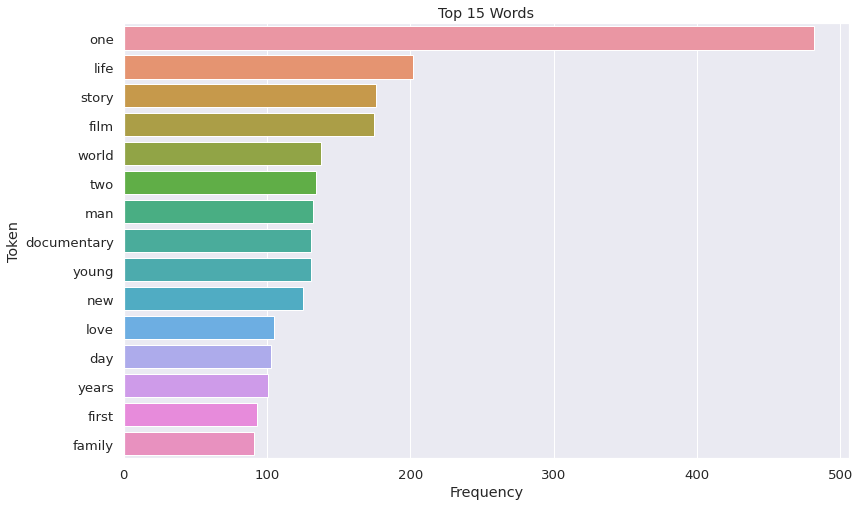

In [22]:
# Plot Frequency Diagram
plt.figure(figsize=(13,8))
sns.set(font_scale = 1.2)
sns.barplot(x="freq", y="token", data=freq_df.head(15), orient = "h")
#ax.invert_yaxis()
plt.title("Top 15 Words")
plt.xlabel("Frequency")
plt.ylabel("Token")
plt.show()

## Word Cloud

In [23]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    # Create word cloud
    wc = WordCloud(width=800, height=400,
        background_color= "black", colormap="Paired",
        max_font_size=150, max_words=max_words)

    # convert DataFrame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq
    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() if token not in stopwords}

    wc.generate_from_frequencies(counter)
    plt.title(title)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

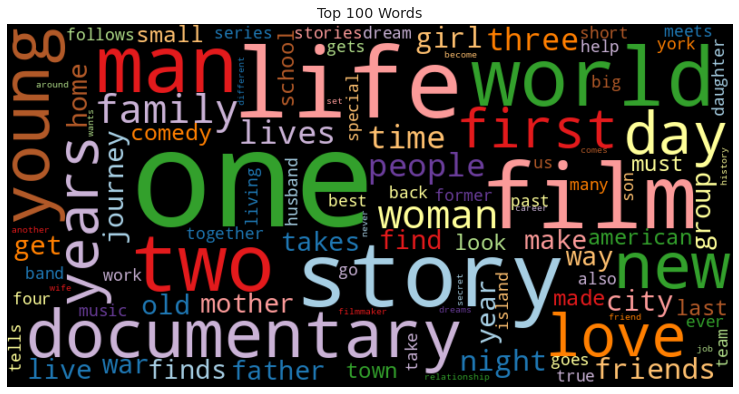

In [24]:
# Plot Word Cloud
plt.figure(figsize=(13,8))
freq_df = count_words(cleaned_df)
wordcloud(freq_df['freq'], max_words=100)
plt.title("Top 100 Words")
plt.show()


## Export Final Clean Dataset

In [25]:
# Write to a csv
cleaned_df.to_csv('Cleaned Plot Data.csv', index = False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=53ef1faa-b7a9-4637-b54c-3b067e58670d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>